In [1]:
import os
import h5py
import numpy as np
import cv2
from kymatio import Scattering2D
from PIL import Image
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
import scipy
from scipy.ndimage import gaussian_filter1d
from kymatio.numpy import Scattering1D
import fake_spectra as fs
try:
    xrange(1)
except NameError:
    xrange = range

In [2]:
sim_res= 100

def get_mean_flux_scale(tau, desired_mean_flux, nbins, tol):
    newscale =1
    scale=0
    while np.abs(newscale-scale) > (tol*newscale):
        
        scale= newscale
        mean_flux =0
        tau_mean_flux =0
        nbins_used=0
        tau_mean=[]
        for i in range(0, 32000):
            tau_mean.append(np.mean(tau[i]))
        
       
        for i in range(0, nbins):
            temp= np.exp(-scale*tau_mean[i])
            mean_flux= mean_flux+temp
            tau_mean_flux = tau_mean_flux+temp*tau_mean[i]
            nbins_used=nbins_used+1
        
        newscale=scale+(mean_flux- desired_mean_flux * nbins_used)/tau_mean_flux

        if newscale <= 0:
            newscale=1e-10
            
    return newscale

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def _powerspectrum(inarray, axis=-1):
    """Compute the power spectrum of the input using np.fft"""
    rfftd = np.fft.rfft(inarray, axis=axis)
    # Want P(k)= F(k).re*F(k).re+F(k).im*F(k).im
    power = np.abs(rfftd)**2
    #Normalise the FFT so it is independent of input size.
    power /= np.shape(inarray)[axis]**2
    return power

def truncated_gaussian_samples(mean, std_dev, a, b, num_samples_):
    samples = []
    while len(samples) < num_samples_:
        value = np.random.normal(mean, std_dev)
        if a <= value <= b:
            samples.append(value)
    return samples

def add_noise(snr, flux, spec_num=-1):
        """Compute a Gaussian noise vector from the flux variance and the SNR, as computed from optical depth
        Parameters:
        snr : an array of signal to noise ratio (constant along each sightine)
        flux : an array of spectra (flux)  we want to add noise to
        spec_num : the index to spectra we want to add nose to. Leave it as -1 to add the noise to all spectra.
        """
        nbins=flux.shape[1]
        noise_array = np.array([])
        if np.size(np.shape(flux)) == 1:
            lines = 1
        else:
            lines = np.shape(flux)[0]
        #This is to get around the type rules.
        if lines == 1:
            #This ensures that we always get the same noise for the same spectrum
            np.random.seed(spec_num)
            flux += np.random.normal(0, 1./snr[spec_num], nbins)
        else:
            for ii in xrange(lines):
                np.random.seed(ii)
                noise = truncated_gaussian_samples(0, 1./snr[ii], -np.min(flux[ii]), np.max(flux[ii]), nbins)
                noise_array = np.append(noise_array, noise)
                
                flux[ii]+= noise
                
        return (flux, noise_array)


    
def obs_mean_tau(redshift):
    return 0.0023*(1.0+redshift)**3.65



def scale_factor_to_redshift(scale_factor):
    return (1 / scale_factor) - 1


In [3]:
lya_file = h5py.File('/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
        
## adjusting for mean flux and smoothing the data
rescaled_tau = rescale_factor*all_tau
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.29)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux

## 32000 spectra

In [4]:
#covariance matrices
cov_z2_st= np.loadtxt('/Users/Hurum/Documents/simulation_new/new_st_first_sec.txt')
cov_z2_st1= np.loadtxt('/Users/Hurum/Documents/simulation_new/new_st_first.txt')
cov_z2_st2= np.loadtxt('/Users/Hurum/Documents/simulation_new/new_st_sec.txt')

cov_z3_st= np.loadtxt('/Users/Hurum/Documents/simulation_new/new_st_first_sec_z3.txt')
cov_z4_st= np.loadtxt('/Users/Hurum/Documents/simulation_new/new_st_first_sec_z4.txt')

cov_z2_ps=1.7237333898139144e-08
cov_z3_ps= 9.716355913703804e-09
cov_z4_ps= 2.4712935419877078e-08

In [8]:
##setting up
J = 5
Q = 1

N = 370
S_z2 = Scattering1D(J, N, Q)


N = 405
S_z3 = Scattering1D(J, N, Q)

N = 456
S_z4 = Scattering1D(J, N, Q)


In [15]:
#ns
from scipy.ndimage import gaussian_filter1d as gf
from fake_spectra import fluxstatistics as fs

sim_list=['/Users/Hurum/Documents/z=2/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/simulation_new/ns0.946_z_2/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.946]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4177
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z2(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


In [16]:
st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_ns_z2= np.matmul(dcl_dp[1:19],ds_dp_cov)
print(np.sqrt(1/F_ns_z2))


0.005902192955608688


In [17]:

dcl_dp= [(ps_mean[0]-ps_mean[1])/(ns_values[0]-ns_values[1]),(ps_mean[1]-ps_mean[2])/(ns_values[1]-ns_values[2]),(ps_mean[0]-ps_mean[2])/(ns_values[0]-ns_values[2])]
dcl_dp=np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z2_ps
F_ps_ns = dcl_dp**2*inv_diag
print(np.sqrt(1/F_ps_ns))

0.1784119185316278


In [19]:
dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st1)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:7]))
F_ns_z2_first= np.matmul(dcl_dp[1:7],ds_dp_cov)

dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[2]-st[0])/(ns_values[2]-ns_values[0])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st2)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[7:19]))
F_ns_z2_sec= np.matmul(dcl_dp[7:19],ds_dp_cov)

In [20]:
sim_list_As=['/Users/Hurum/Documents/z=2/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=2/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']


As_values = [2.25, 1.2, 1.55]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4177
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z2(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


In [21]:
st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_As_z2= np.matmul(dcl_dp[1:19],ds_dp_cov)
print(np.sqrt(1/F_As_z2))


dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st1)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:7]))
F_As_z2_first= np.matmul(dcl_dp[1:7],ds_dp_cov)

dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st2)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[7:19]))
F_As_z2_sec= np.matmul(dcl_dp[7:19],ds_dp_cov)

dcl_dp= [(ps_mean[0]-ps_mean[1])/(As_values[0]-As_values[1]),(ps_mean[1]-ps_mean[2])/(As_values[1]-As_values[2]),(ps_mean[0]-ps_mean[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z2_ps
F_ps_As =  dcl_dp**2*inv_diag
print(np.sqrt(1/F_ps_As))

0.007873122572171045
0.5031630431939013


In [22]:
sim_list_Hs=['/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

Hs_values = [-.5, -.1, -.7]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4177
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z2(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


In [23]:
st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_Hs_z2= np.matmul(dcl_dp[1:19],ds_dp_cov)
print(np.sqrt(1/F_Hs_z2))

dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st1)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:7]))
F_Hs_z2_first= np.matmul(dcl_dp[1:7],ds_dp_cov)

dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st2)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[7:19]))
F_Hs_z2_sec= np.matmul(dcl_dp[7:19],ds_dp_cov)

dcl_dp= [(ps_mean[0]-ps_mean[1])/(Hs_values[0]-Hs_values[1]),(ps_mean[1]-ps_mean[2])/(Hs_values[1]-Hs_values[2]),(ps_mean[0]-ps_mean[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z2_ps
F_ps_Hs = dcl_dp**2*inv_diag
print(np.sqrt(1/F_ps_Hs))


0.004961891994741143
0.20712464371427694


In [24]:
sim_list_Ha=['/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]

Ha_values = [.9, 1.4, .65]


st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4177
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z2(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


In [25]:
st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_Ha_z2= np.matmul(dcl_dp[1:19],ds_dp_cov)
print(np.sqrt(1/F_Ha_z2))

dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st1)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:7]))
F_Ha_z2_first= np.matmul(dcl_dp[1:7],ds_dp_cov)

dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z2_st2)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[7:19]))
F_Ha_z2_sec= np.matmul(dcl_dp[7:19],ds_dp_cov)

dcl_dp= [(ps_mean[0]-ps_mean[1])/(Ha_values[0]-Ha_values[1]),(ps_mean[1]-ps_mean[2])/(Ha_values[1]-Ha_values[2]),(ps_mean[0]-ps_mean[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z2_ps
F_ps_Ha =  dcl_dp**2*inv_diag
print(np.sqrt(1/F_ps_Ha))


0.0062023649933630395
0.2589058046428462


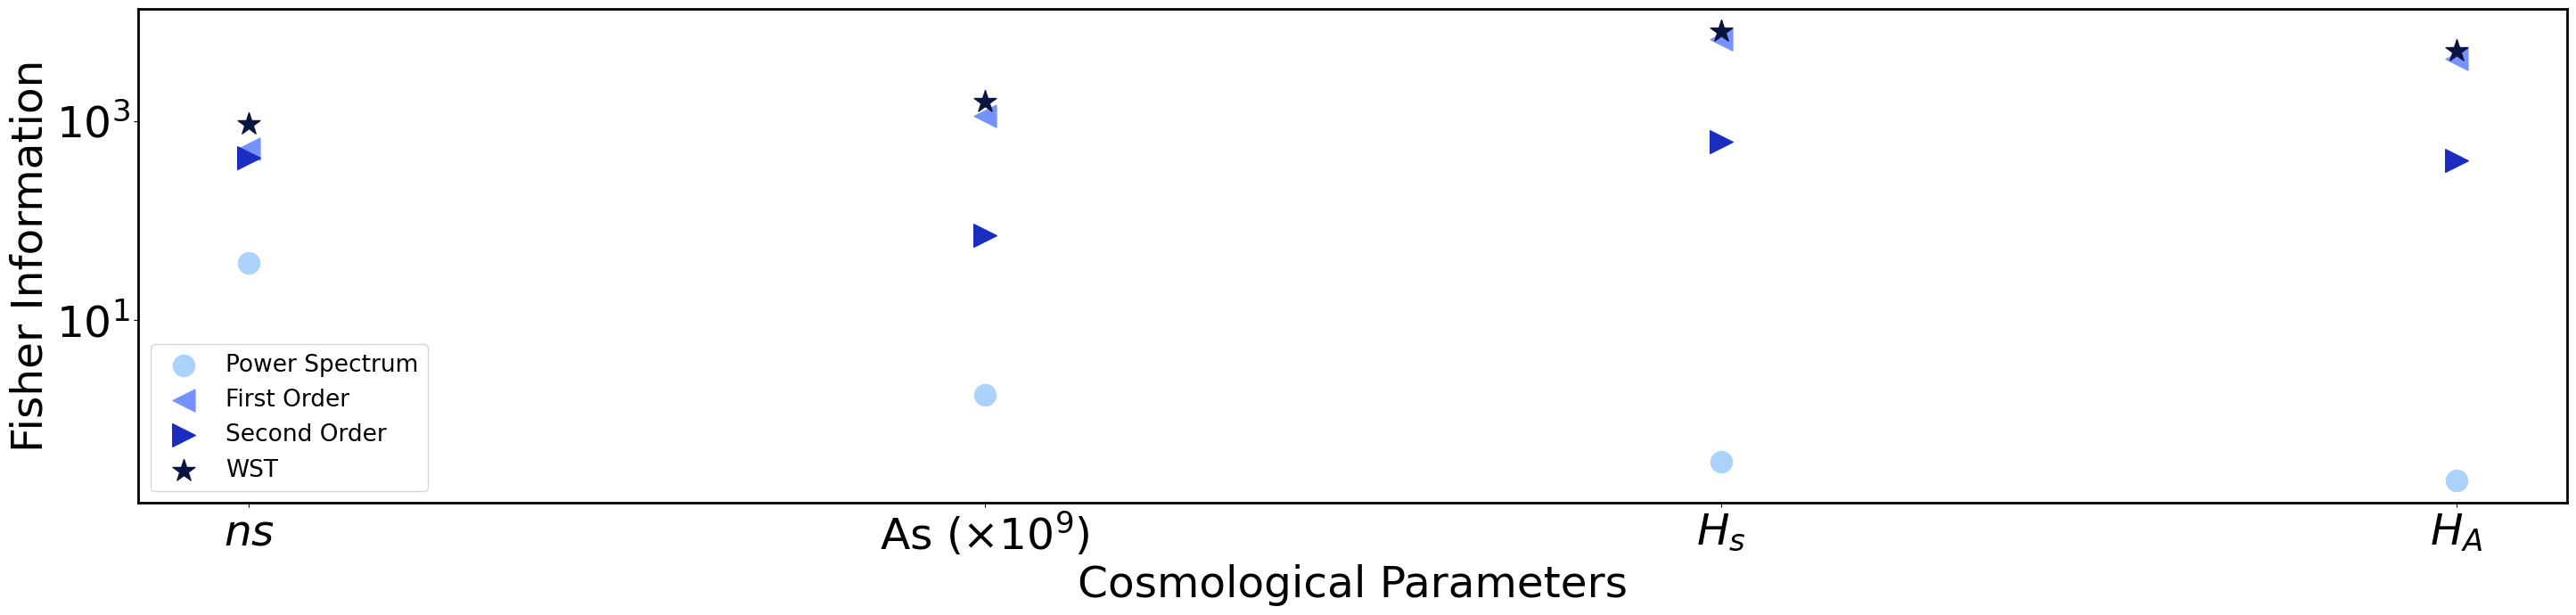

In [27]:
param= ['$ns$', r'As ($\times 10^9$)', r'$H_s$', r'$H_A$']
plt.scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA', label='Power Spectrum')
plt.scatter(param, [F_ns_z2_first, F_As_z2_first , F_Hs_z2_first, F_Ha_z2_first],color = '#7692FF', s= 320, marker='<' , label='First Order')
plt.scatter(param, [F_ns_z2_sec, F_As_z2_sec , F_Hs_z2_sec, F_Ha_z2_sec], color='#1B2CC1', s= 340, marker='>' , label='Second Order')
plt.scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 350, color='#091540',marker='*' , label='WST')
plt.yscale('log')
plt.legend(loc='lower left', fontsize= 19)
plt.xlabel('Cosmological Parameters')
plt.ylabel(r'Fisher Information')
plt.tight_layout()
plt.savefig('1Dparam.pdf')

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import cv2
from kymatio import Scattering2D
from PIL import Image
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
import scipy
from scipy.ndimage import gaussian_filter1d

try:
    xrange(1)
except NameError:
    xrange = range



matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["figure.figsize"] = [10.0,8.0]
axislabelfontsize= 54

matplotlib.mathtext.rcParams['legend.fontsize']=20


matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


plt.rc("axes", linewidth=2.0)
plt.rc("lines", markeredgewidth=3)
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize = 32)
plt.rc('ytick', labelsize = 32)

fig_width_pt = 1000 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean=0.9
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
             'axes.labelsize': 54,
             'lines.markersize': 4,
             'font.size': 100,
             'xtick.major.size':6,
             'xtick.minor.size':3,
             'ytick.major.size':6,
             'ytick.minor.size':3,
             'xtick.major.width':0.5,
             'ytick.major.width':0.5,
             'xtick.minor.width':0.5,
             'ytick.minor.width':0.5,
             'lines.markeredgewidth':1,
             'axes.linewidth':1.2,
             'xtick.labelsize': 32,
             'ytick.labelsize': 32,
             'savefig.dpi':2000,
   #      'path.simplify':True,
         'font.family': 'serif',
         'font.serif':'Times',
             'text.usetex':True,
             'text.latex.preamble': [r'\usepackage{amsmath}'],
             'figure.figsize': fig_size}



In [26]:
sim_list=['/Users/Hurum/Documents/z=3/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4457.58
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z3(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)
    



st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z3_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_ns_z3= np.matmul(dcl_dp[1:19],ds_dp_cov)



dcl_dp= [(ps_mean[0]-ps_mean[1])/(ns_values[0]-ns_values[1]),(ps_mean[1]-ps_mean[2])/(ns_values[1]-ns_values[2]),(ps_mean[0]-ps_mean[2])/(ns_values[0]-ns_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z3_ps
F_ps_ns_z3 = dcl_dp**2*inv_diag



sim_list_As=['/Users/Hurum/Documents/z=3/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=3/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']


As_values = [2.25, 1.2, 1.55]

st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4457.58
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z3(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)
    
st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z3_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_As_z3= np.matmul(dcl_dp[1:19],ds_dp_cov)



dcl_dp= [(ps_mean[0]-ps_mean[1])/(As_values[0]-As_values[1]),(ps_mean[1]-ps_mean[2])/(As_values[1]-As_values[2]),(ps_mean[0]-ps_mean[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z3_ps
F_ps_As_z3 = dcl_dp**2*inv_diag


sim_list_Hs=['/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

Hs_values = [-.5, -.1, -.7]
st=[]
ps_mean=[]



for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4457.58
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z3(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)

st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z3_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_Hs_z3= np.matmul(dcl_dp[1:19],ds_dp_cov)


dcl_dp= [(ps_mean[0]-ps_mean[1])/(Hs_values[0]-Hs_values[1]),(ps_mean[1]-ps_mean[2])/(Hs_values[1]-Hs_values[2]),(ps_mean[0]-ps_mean[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z3_ps
F_ps_Hs_z3 = dcl_dp**2*inv_diag



sim_list_Ha=['/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=3/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]

Ha_values = [.9, 1.4, .65]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.25)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 4457.58
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z3(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)

st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z3_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_Ha_z3= np.matmul(dcl_dp[1:19],ds_dp_cov)




dcl_dp= [(ps_mean[0]-ps_mean[1])/(Ha_values[0]-Ha_values[1]),(ps_mean[1]-ps_mean[2])/(Ha_values[1]-Ha_values[2]),(ps_mean[0]-ps_mean[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z3_ps
F_ps_Ha_z3 = dcl_dp**2*inv_diag





In [27]:
sim_list=['/Users/Hurum/Documents/z=4/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

ns_values = [0.8, 0.849, 0.897]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 5039.36
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z4(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(ns_values[0]-ns_values[1]),(st[1]-st[2])/(ns_values[1]-ns_values[2]),(st[0]-st[2])/(ns_values[0]-ns_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z4_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_ns_z4= np.matmul(dcl_dp[1:19],ds_dp_cov)



dcl_dp= [(ps_mean[0]-ps_mean[1])/(ns_values[0]-ns_values[1]),(ps_mean[1]-ps_mean[2])/(ns_values[1]-ns_values[2]),(ps_mean[0]-ps_mean[2])/(ns_values[0]-ns_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z4_ps
F_ps_ns_z4 = dcl_dp**2*inv_diag



sim_list_As=['/Users/Hurum/Documents/z=4/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=4/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5']


As_values = [2.25, 1.2, 1.55]

st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_As[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 5039.36
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z4(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(As_values[0]-As_values[1]),(st[1]-st[2])/(As_values[1]-As_values[2]),(st[0]-st[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z4_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_As_z4= np.matmul(dcl_dp[1:19],ds_dp_cov)



dcl_dp= [(ps_mean[0]-ps_mean[1])/(As_values[0]-As_values[1]),(ps_mean[1]-ps_mean[2])/(As_values[1]-As_values[2]),(ps_mean[0]-ps_mean[2])/(As_values[0]-As_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z4_ps
F_ps_As_z4 = dcl_dp**2*inv_diag


sim_list_Hs=['/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5']

Hs_values = [-.5, -.1, -.7]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Hs[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 5039.36
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z4(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(Hs_values[0]-Hs_values[1]),(st[1]-st[2])/(Hs_values[1]-Hs_values[2]),(st[0]-st[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z4_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_Hs_z4= np.matmul(dcl_dp[1:19],ds_dp_cov)


dcl_dp= [(ps_mean[0]-ps_mean[1])/(Hs_values[0]-Hs_values[1]),(ps_mean[1]-ps_mean[2])/(Hs_values[1]-Hs_values[2]),(ps_mean[0]-ps_mean[2])/(Hs_values[0]-Hs_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z4_ps
F_ps_Hs_z4 = dcl_dp**2*inv_diag



sim_list_Ha=['/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=4/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5' ]

Ha_values = [.9, 1.4, .65]
st=[]
ps_mean=[]

for i in range(0,3):
    lya_file = h5py.File(sim_list_Ha[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))

    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.192)
    res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    tau_ = -np.log(all_flux)
    
    vmax = 5039.36
    spec_res = vmax/tau_.shape[1]
    kf, mean_flux_power = fs.flux_power(tau_, vmax= vmax, spec_res= spec_res)

    mean_flux_power = mean_flux_power*kf/np.pi
    ps=[]
    for i in range(0,len(kf)):
        if kf[i]< 0.5:
            ps.append(mean_flux_power[i])

    ps_mean.append(np.mean(ps))

    

    all_flux= coarse_flux/np.mean(all_flux)-1
    
    
    coeff=[]
    for i in range(0,32000):
        coeffs = S_z4(all_flux[i])
        coeffs = coeffs.mean(axis=1)
        coeff.append(coeffs) 
    
    st.append(coeff)


st= np.array(st)
st = st.mean(axis=1)
dcl_dp= [(st[0]-st[1])/(Ha_values[0]-Ha_values[1]),(st[1]-st[2])/(Ha_values[1]-Ha_values[2]),(st[0]-st[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= np.linalg.inv(cov_z4_st)
ds_dp_cov = np.matmul(inv_diag, np.transpose(dcl_dp[1:19]))
F_Ha_z4= np.matmul(dcl_dp[1:19],ds_dp_cov)



dcl_dp= [(ps_mean[0]-ps_mean[1])/(Ha_values[0]-Ha_values[1]),(ps_mean[1]-ps_mean[2])/(Ha_values[1]-Ha_values[2]),(ps_mean[0]-ps_mean[2])/(Ha_values[0]-Ha_values[2])]
dcl_dp= np.array(dcl_dp)
dcl_dp = dcl_dp.mean(axis=0)
inv_diag= 1/cov_z4_ps
F_ps_Ha_z4 = dcl_dp**2*inv_diag




In [22]:
np.savetxt('stz21D.txt',[F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2])
np.savetxt('psz21D.txt',[F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha])

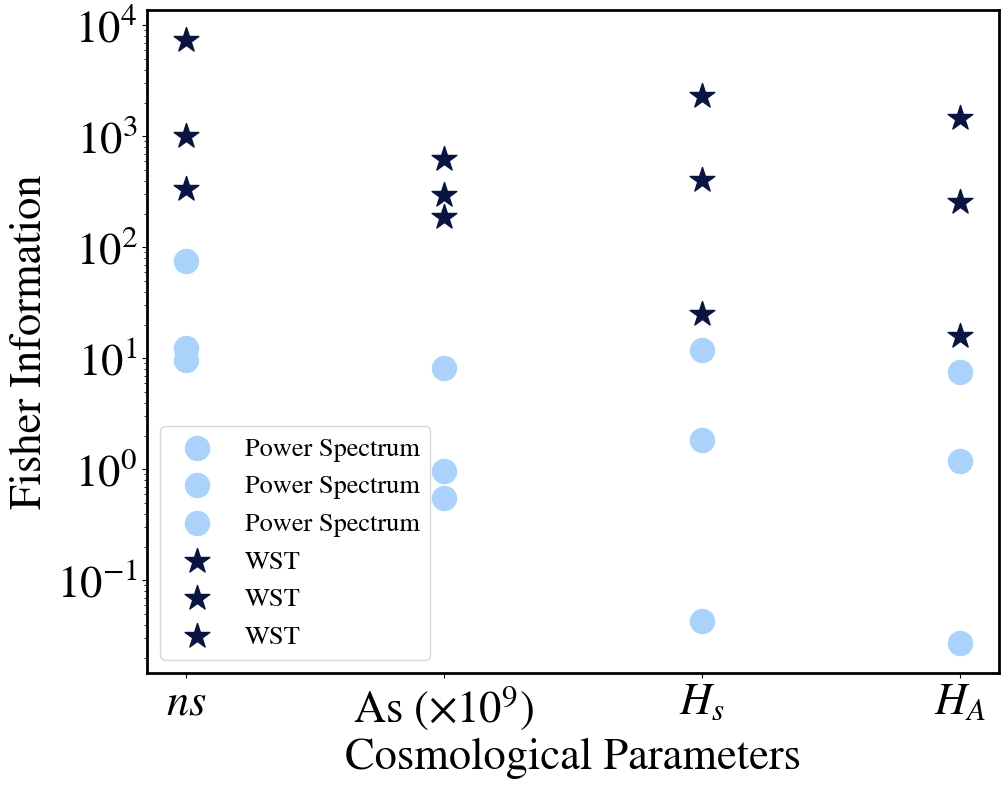

In [23]:
param= ['$ns$', r'As ($\times 10^9$)', r'$H_s$', r'$H_A$']
plt.scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA', label='Power Spectrum')
plt.scatter(param, [F_ps_ns_z3,F_ps_As_z3,F_ps_Hs_z3,F_ps_Ha_z3], s= 300, marker='o' , color='#ABD2FA', label='Power Spectrum')
plt.scatter(param, [F_ps_ns_z4,F_ps_As_z4,F_ps_Hs_z4,F_ps_Ha_z4], s= 300, marker='o' , color='#ABD2FA', label='Power Spectrum')

plt.scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 350, color='#091540',marker='*' , label='WST')
plt.scatter(param, [F_ns_z3, F_As_z3 , F_Hs_z3, F_Ha_z3], s= 350, color='#091540',marker='*' , label='WST')
plt.scatter(param, [F_ns_z4, F_As_z4 , F_Hs_z4, F_Ha_z4], s= 350, color='#091540',marker='*' , label='WST')
plt.yscale('log')
plt.legend(loc='lower left', fontsize= 19)
plt.xlabel('Cosmological Parameters')
plt.ylabel(r'Fisher Information')
plt.tight_layout()

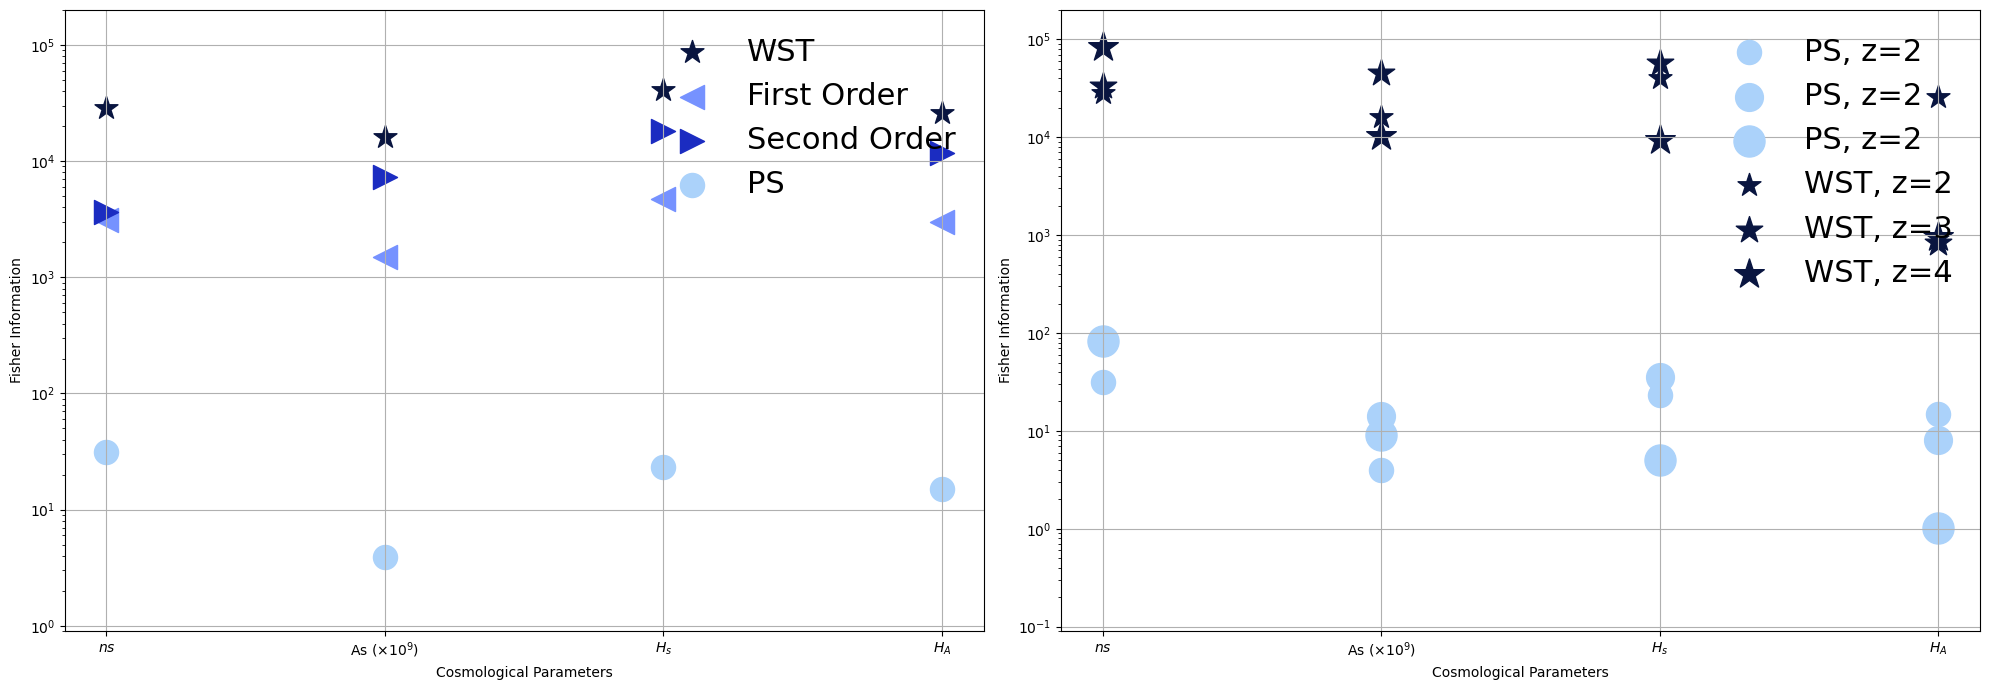

In [43]:

plt.rcParams["figure.figsize"] = [20.0,7.0]
fig, axs = plt.subplots(nrows=1, ncols=2)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 300, color='#091540',marker='*' , label='WST')
axs[0].scatter(param, [F_ns_z2_first, F_As_z2_first , F_Hs_z2_first, F_Ha_z2_first],color = '#7692FF', s= 300, marker='<' , label='First Order')
axs[0].scatter(param, [F_ns_z2_sec, F_As_z2_sec , F_Hs_z2_sec, F_Ha_z2_sec], color='#1B2CC1', s= 300, marker='>' , label='Second Order')
axs[0].scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA', label='PS')

axs[0].set_yscale('log')
axs[0].grid('true')
axs[0].set_ylabel(r'Fisher Information')
axs[0].set_xlabel(r'Cosmological Parameters')



axs[1].scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA', label='PS, z=2')
axs[1].scatter(param, [F_ps_ns_z3,F_ps_As_z3,F_ps_Hs_z3,F_ps_Ha_z3], s= 400, marker='o' , color='#ABD2FA', label='PS, z=2')
axs[1].scatter(param, [F_ps_ns_z4,F_ps_As_z4,F_ps_Hs_z4,F_ps_Ha_z4], s= 500, marker='o' , color='#ABD2FA', label='PS, z=2')

axs[1].scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 300, color='#091540',marker='*' , label='WST, z=2')
axs[1].scatter(param, [F_ns_z3, F_As_z3 , F_Hs_z3, F_Ha_z3], s= 400, color='#091540',marker='*' , label='WST, z=3')
axs[1].scatter(param, [F_ns_z4, F_As_z4 , F_Hs_z4, F_Ha_z4], s= 500, color='#091540',marker='*' , label='WST, z=4')

axs[1].set_yscale('log')
axs[1].grid('true')
axs[1].set_ylabel(r'Fisher Information')
axs[1].set_xlabel(r'Cosmological Parameters')


axs[0].legend(framealpha=0, loc = 'upper right', fontsize = 22)
axs[1].legend(framealpha=0,loc = 'upper right', fontsize = 22)

axs[0].set_ylim([9e-1,2e5])
axs[1].set_ylim([9e-2,2e5])



#axs[2].set_ylim([0.065,0.085])

#axs[0].set_title('First Order', size = 25)
#axs[1].set_title('Second Order', size = 25)
#axs[2].set_title('Second Order', size = 25)
plt.tight_layout()





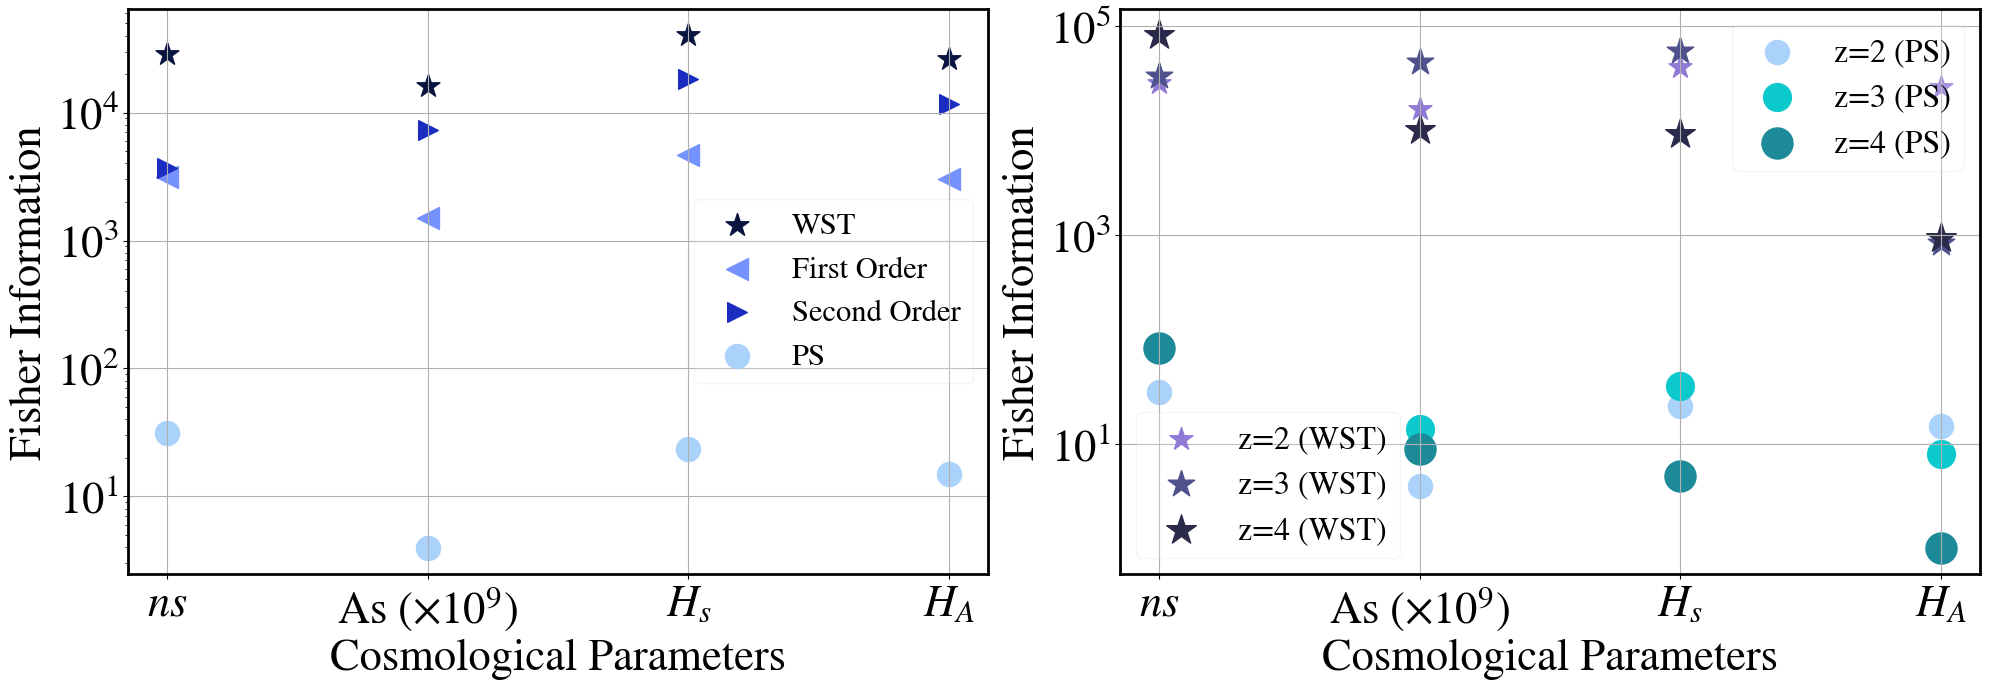

In [50]:

plt.rcParams["figure.figsize"] = [20.0,7.0]
fig, axs = plt.subplots(nrows=1, ncols=2)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 300, color='#091540',marker='*' , label='WST')
axs[0].scatter(param, [F_ns_z2_first, F_As_z2_first , F_Hs_z2_first, F_Ha_z2_first],color = '#7692FF', s= 250, marker='<' , label='First Order')
axs[0].scatter(param, [F_ns_z2_sec, F_As_z2_sec , F_Hs_z2_sec, F_Ha_z2_sec], color='#1B2CC1', s= 200, marker='>' , label='Second Order')
axs[0].scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA', label='PS')

axs[0].set_yscale('log')
axs[0].grid('true')
axs[0].set_ylabel(r'Fisher Information')
axs[0].set_xlabel(r'Cosmological Parameters')


sc1 = axs[1].scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA')
sc2 = axs[1].scatter(param, [F_ps_ns_z3,F_ps_As_z3,F_ps_Hs_z3,F_ps_Ha_z3], s= 400, marker='o' , color='#0BC9CD')
sc3 = axs[1].scatter(param, [F_ps_ns_z4,F_ps_As_z4,F_ps_Hs_z4,F_ps_Ha_z4], s= 500, marker='o' , color='#1D8A99')

sc4 = axs[1].scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 300, color='#907AD6',marker='*' )
sc5 = axs[1].scatter(param, [F_ns_z3, F_As_z3 , F_Hs_z3, F_Ha_z3], s= 400, color='#4F518C',marker='*' )
sc6 = axs[1].scatter(param, [F_ns_z4, F_As_z4 , F_Hs_z4, F_Ha_z4], s= 500, color='#2C2A4A',marker='*' )

legend1 = axs[1].legend([sc1, sc2, sc3], ['z=2 (PS)', 'z=3 (PS)', 'z=4 (PS)'], framealpha=0.2, loc = 'upper right', fontsize = 23)
legend2 = axs[1].legend([sc4, sc5, sc6], ['z=2 (WST)', 'z=3 (WST)', 'z=4 (WST)'], framealpha=0.2, loc = 'lower left', fontsize = 23)

# Manually add the first legend back
axs[1].add_artist(legend1)


axs[1].set_yscale('log')
axs[1].grid('true')
axs[1].set_ylabel(r'Fisher Information')
axs[1].set_xlabel(r'Cosmological Parameters')


axs[0].legend(framealpha=0.2,  fontsize = 22)
#axs[1].legend(framealpha=0,loc = 'upper right', fontsize = 22)


#axs[2].set_ylim([0.065,0.085])

#axs[0].set_title('First Order', size = 25)
#axs[1].set_title('Second Order', size = 25)
#axs[2].set_title('Second Order', size = 25)
plt.tight_layout()

plt.savefig('wst_comp_new.pdf')

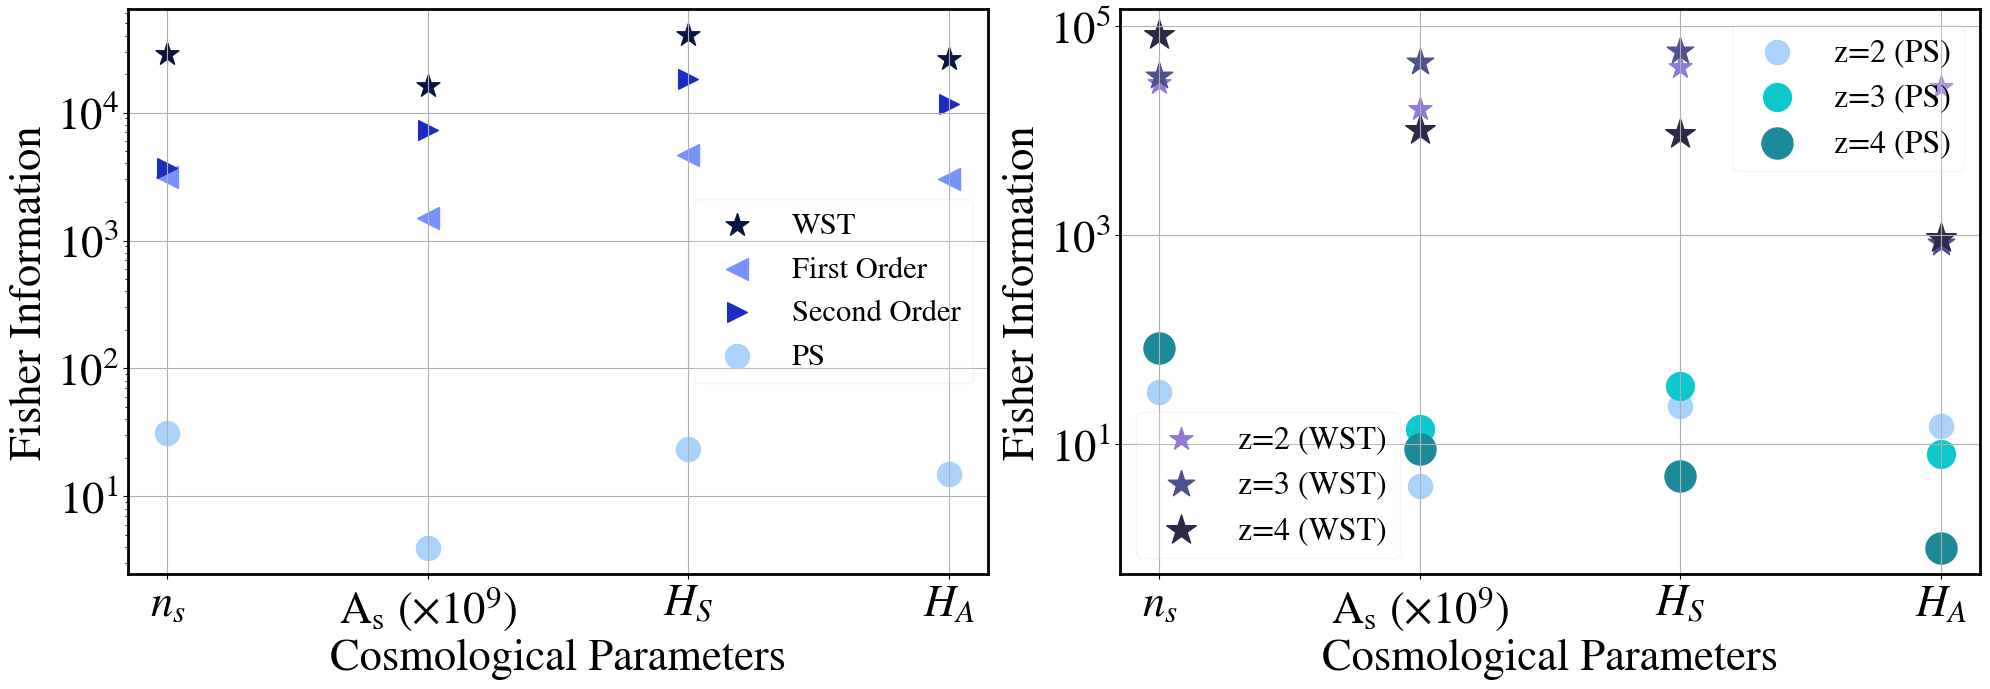

In [32]:
param= ['$n_s$', r'A$_\mathrm{s}$ ($\times 10^9$)', r'$H_S$', r'$H_A$']

plt.rcParams["figure.figsize"] = [20.0,7.0]
fig, axs = plt.subplots(nrows=1, ncols=2)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 300, color='#091540',marker='*' , label='WST')
axs[0].scatter(param, [F_ns_z2_first, F_As_z2_first , F_Hs_z2_first, F_Ha_z2_first],color = '#7692FF', s= 250, marker='<' , label='First Order')
axs[0].scatter(param, [F_ns_z2_sec, F_As_z2_sec , F_Hs_z2_sec, F_Ha_z2_sec], color='#1B2CC1', s= 200, marker='>' , label='Second Order')
axs[0].scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA', label='PS')

axs[0].set_yscale('log')
axs[0].grid('true')
axs[0].set_ylabel(r'Fisher Information')
axs[0].set_xlabel(r'Cosmological Parameters')


sc1 = axs[1].scatter(param, [F_ps_ns,F_ps_As,F_ps_Hs,F_ps_Ha], s= 300, marker='o' , color='#ABD2FA')
sc2 = axs[1].scatter(param, [F_ps_ns_z3,F_ps_As_z3,F_ps_Hs_z3,F_ps_Ha_z3], s= 400, marker='o' , color='#0BC9CD')
sc3 = axs[1].scatter(param, [F_ps_ns_z4,F_ps_As_z4,F_ps_Hs_z4,F_ps_Ha_z4], s= 500, marker='o' , color='#1D8A99')

sc4 = axs[1].scatter(param, [F_ns_z2, F_As_z2 , F_Hs_z2, F_Ha_z2], s= 300, color='#907AD6',marker='*' )
sc5 = axs[1].scatter(param, [F_ns_z3, F_As_z3 , F_Hs_z3, F_Ha_z3], s= 400, color='#4F518C',marker='*' )
sc6 = axs[1].scatter(param, [F_ns_z4, F_As_z4 , F_Hs_z4, F_Ha_z4], s= 500, color='#2C2A4A',marker='*' )

legend1 = axs[1].legend([sc1, sc2, sc3], ['z=2 (PS)', 'z=3 (PS)', 'z=4 (PS)'], framealpha=0.2, loc = 'upper right', fontsize = 23)
legend2 = axs[1].legend([sc4, sc5, sc6], ['z=2 (WST)', 'z=3 (WST)', 'z=4 (WST)'], framealpha=0.2, loc = 'lower left', fontsize = 23)

# Manually add the first legend back
axs[1].add_artist(legend1)


axs[1].set_yscale('log')
axs[1].grid('true')
axs[1].set_ylabel(r'Fisher Information')
axs[1].set_xlabel(r'Cosmological Parameters')


axs[0].legend(framealpha=0.2,  fontsize = 22)
#axs[1].legend(framealpha=0,loc = 'upper right', fontsize = 22)


#axs[2].set_ylim([0.065,0.085])

#axs[0].set_title('First Order', size = 25)
#axs[1].set_title('Second Order', size = 25)
#axs[2].set_title('Second Order', size = 25)
plt.tight_layout()

plt.savefig('wst_comp_new.pdf')